# Mitigation Bias 

The objective of this notebook is to characterize the bias that is introduced in the power spectrum measurement after correcting the density field of quasars for imaging systematic effects.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from glob import glob
import nbodykit.lab as nb
from tqdm.notebook import tqdm
import sys
sys.path.append('../scripts/analysis/')
from compute_mitigationbias import Spectra, solve

In [2]:
from glob import glob

In [3]:
class MitigBias:
    def __init__(self):
        p = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
        self.params = np.loadtxt(f'{p}pk_params_NGC_512_known.txt')
    
    def debias(self, pk):
        return (1.-self.params[:, 1])*pk - self.params[:, 2]
    
def readpk(pki):
    dpk = nb.ConvolvedFFTPower.load(pki) 
    dpk_ = dpk.poles['power_0'].real-dpk.attrs['shotnoise']    
    return dpk.poles['k'], dpk_

In [4]:
mb = MitigBias()

In [5]:
cap = 'NGC'
method = 'known'
nside = '512'
iscont = '1'

path = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
pks = glob(f'{path}spectra_{cap}_{method}_mainhighz_{nside}_v7_{iscont}_*_main.json')

nmocks = len(pks)
print(nmocks)

1000


In [7]:
fixpk = lambda pki:pki.replace('known', 'knownsystot').replace('_1_', '_0_')

In [8]:
pk = []
pkn = []
pkd = []

for pki in tqdm(pks):
    k, dpk_ = readpk(pki)
    _, dpk_n = readpk(fixpk(pki))
    pk.append(dpk_)
    pkn.append(dpk_n)
    pkd.append(mb.debias(dpk_))
    
pk = np.array(pk)
pkn = np.array(pkn)
pkd = np.array(pkd)

In [9]:
# pkm = np.load('pk_ezmocks_ngcsgc_v1.0.npz', allow_pickle=True)

In [10]:
pk_bins = np.percentile(pk[:, 1], [0, 33.3, 66.6, 100])
pk_ind = np.digitize(pk[:, 1], pk_bins)

In [11]:
for i in range(pk_ind.max()):
    print(i, np.argwhere(pk_ind == i).flatten()[:10])

0 []
1 [ 1  4  6  7 11 12 13 17 22 24]
2 [ 5 19 21 23 25 29 33 36 40 41]
3 [ 0  2  3  8  9 10 14 15 16 18]


In [12]:
plt.rc('font', size=14)

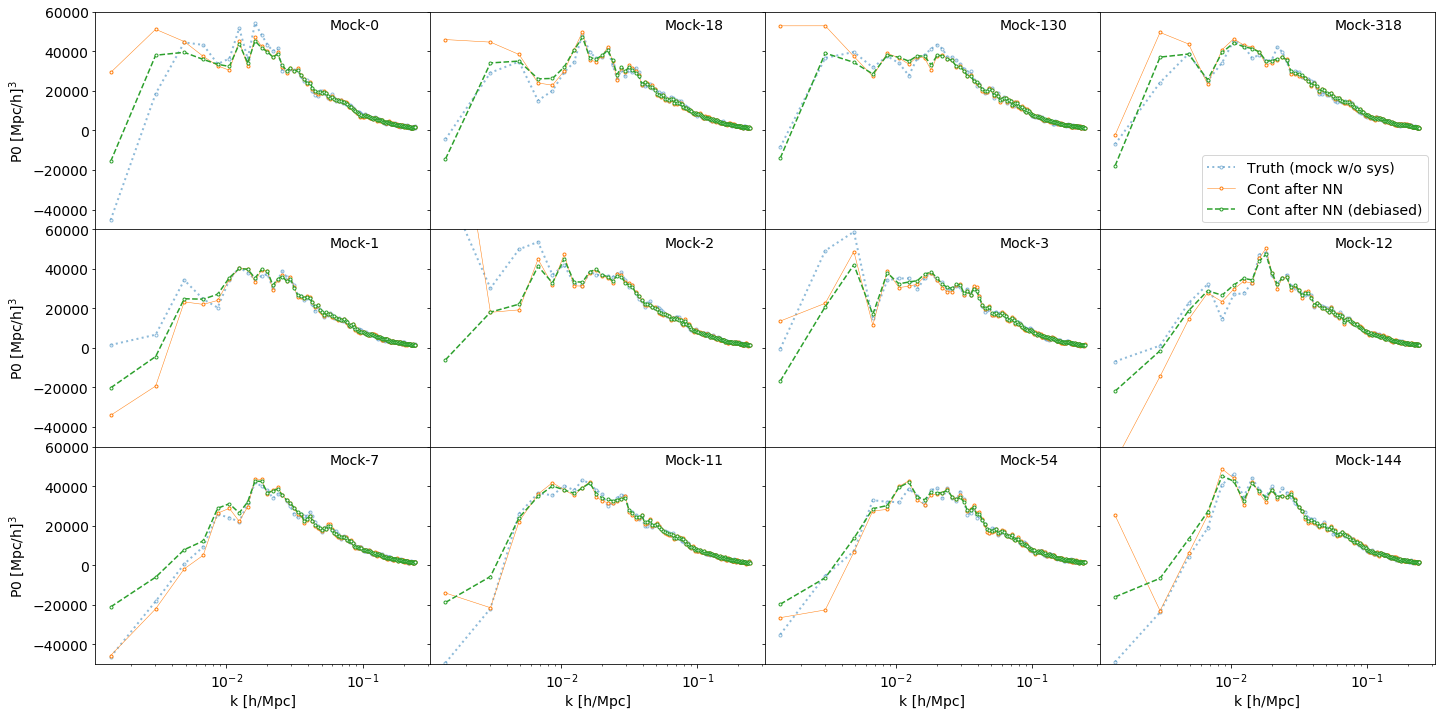

In [13]:
#plt.figure(figsize=(8, 6))

fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(24, 12), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0.)
ax = ax.flatten()


#plt.plot(k, np.mean(pk, axis=0), 'k-', label='Mean')
#plt.plot(k, mb.debias(np.mean(pk, axis=0)), 'k--', label='Mean (debiased)')

# l, = .plot(k, pkn[0], ':', label='Truth Mock 1')
# plt.plot(k, pk[0], '-', label='Mock 1', lw=0.5, color=l.get_color())
# plt.plot(k, mb.debias(pk[0]), '--', label='Mock 1 (debiased)', color=l.get_color())

for i, ix in enumerate([0, 18, 130, 318, 1, 2, 3, 12, 7, 11, 54, 144]):
    
    #line, = plt.plot(k, pk[i], '-', lw=0.5)
    #plt.plot(k, pkn[i], ':', color=line.get_color())
    #plt.plot(k, mb.debias(pk[i]), '--', color=line.get_color())
    
    l, = ax[i].plot(k, pkn[ix], '.:',  mfc='w', label='Truth (mock w/o sys)', lw=2, alpha=0.5)
    ax[i].plot(k, pk[ix], '.-', lw=0.5, mfc='w', label='Cont after NN')
    ax[i].plot(k, pkd[ix], '.--', mfc='w', label='Cont after NN (debiased)')
    
    #ax[i].plot(pkm['NGC_null_standard_512'][:, 0], pkm['NGC_null_standard_512'][:, 2], ':', color='k', label='Mean Truth')
    ax[i].text(0.7, 0.92, 'Mock-%d'%ix, transform=ax[i].transAxes)

ax[0].set_ylim(-5.0e4, 6.0e4)
ax[3].legend()
ax[0].set_xscale('log')

for i in range(len(ax)):
    if i%4==0:ax[i].set_ylabel(r'P0 [Mpc/h]$^{3}$')
    if i>7:ax[i].set_xlabel('k [h/Mpc]')

plt.savefig('pmocks_afew.png', dpi=300, bbox_inches='tight')

In [14]:
ix = pk_ind == 1
pkn[ix].shape

(333, 128)

In [17]:
k[5]

0.01049533751540886

0.01049533751540886 62754484.0
0.01049533751540886 65084468.0
0.01049533751540886 36455316.4430428


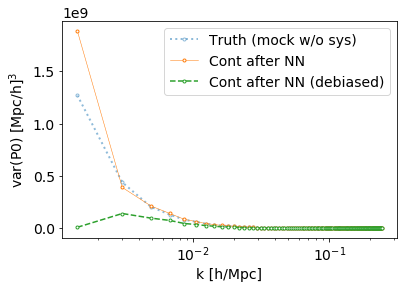

In [18]:
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(6,4), sharex=True, sharey=True)
    
vt = np.var(pkn, axis=0)
vc = np.var(pk, axis=0)
vd = np.var(pkd, axis=0)

ax.plot(k, vt, '.:',  mfc='w', label='Truth (mock w/o sys)', lw=2, alpha=0.5)
ax.plot(k, vc, '.-', lw=0.5, mfc='w', label='Cont after NN')
ax.plot(k, vd, '.--', mfc='w', label='Cont after NN (debiased)')
    
for vi in [vt, vc, vd]:
    print(k[5], vi[5])
    
ax.legend()
ax.set_xscale('log')
ax.set_ylabel(r'var(P0) [Mpc/h]$^{3}$')
ax.set_xlabel('k [h/Mpc]')

plt.savefig('pmocks_var.png', dpi=300, bbox_inches='tight')

0.01049533751540886 0.2194145
0.01049533751540886 0.2275209
0.01049533751540886 0.16715973985026253


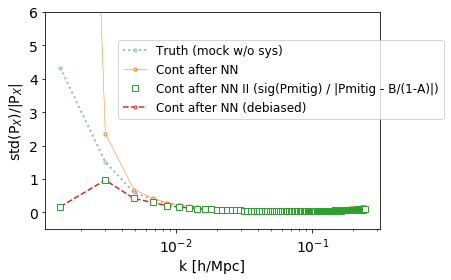

In [43]:
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(6,4), sharex=True, sharey=True)
    
vt = np.std(pkn, axis=0) / abs(np.mean(pkn, axis=0))
vc = np.std(pk, axis=0) / abs(np.mean(pk, axis=0))
vd = np.std(pkd, axis=0) / abs(np.mean(pkd, axis=0))
ve = np.std(pk, axis=0) / abs(np.mean(pk, axis=0) - mb.params[:, 2]/(1-mb.params[:, 1]))

ax.plot(k, vt, '.:',  mfc='w', label='Truth (mock w/o sys)', lw=2, alpha=0.5)
ax.plot(k, vc, '.-', lw=0.5, mfc='w', label='Cont after NN')
ax.plot(k, ve, marker='s', ls='None', mfc='w', label='Cont after NN II (sig(Pmitig) / |Pmitig - B/(1-A)|)')
ax.plot(k, vd, '.--', mfc='w', label='Cont after NN (debiased)', zorder=-10)

    
for vi in [vt, vc, vd]:
    print(k[5], vi[5])
    
ax.legend(bbox_to_anchor=(0.2, 0.9), fontsize=12)
ax.set_xscale('log')
ax.set_ylabel(r'std(P$_{X}$)/|P$_{X}$|')
ax.set_xlabel('k [h/Mpc]')
ax.set_ylim(-0.5, 6)

plt.savefig('pmocks_sigP.png', dpi=300, bbox_inches='tight')

In [33]:
mb.params[5, 1]

0.25158615

In [30]:
(1-mb.params[5, 1])**2

0.5601232908718224

In [31]:
65084468.0 * (1-mb.params[5, 1])**2

36455326.40080182

In [44]:
params = np.loadtxt('/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/pk_params_NGC_512_known_4model.txt')

In [46]:
1+params[:, 1]

array([0.14162834, 0.58676848, 0.72125147, 0.77715117, 0.81520777,
       0.76357793, 0.80633427, 0.83484285, 0.81554835, 0.79498051,
       0.74855785, 0.75535853, 0.79780656, 0.76941751, 0.76718229,
       0.72020672, 0.79980366, 0.78639329, 0.75313874, 0.73741106,
       0.75331097, 0.81532969, 0.75822491, 0.73327227, 0.72289464,
       0.75349129, 0.75203933, 0.74772208, 0.72459475, 0.74575779,
       0.6934384 , 0.67949846, 0.69718378, 0.72310871, 0.68320084,
       0.72324861, 0.7559448 , 0.70937077, 0.73202153, 0.71698694,
       0.7252522 , 0.72118425, 0.74829099, 0.67944446, 0.67581691,
       0.76355699, 0.75010435, 0.71427572, 0.64520532, 0.64578566,
       0.71725565, 0.70106802, 0.67379541, 0.61881418, 0.6784245 ,
       0.61616696, 0.68827505, 0.68416548, 0.67457487, 0.65878828,
       0.7339689 , 0.68168091, 0.70551594, 0.70659892, 0.70550155,
       0.66321527, 0.72613908, 0.6670948 , 0.70915594, 0.64653188,
       0.68090286, 0.69604257, 0.6649991 , 0.6968914 , 0.69626

  1%|          | 1/128 [00:00<00:27,  4.54it/s]

0.0014085807875494757 0.9284187432992339 17764.19612486808


  2%|▏         | 2/128 [00:00<00:27,  4.54it/s]

0.0030163614591330397 0.39811570964157167 -7260.124091653844


  2%|▏         | 3/128 [00:00<00:27,  4.54it/s]

0.0048942687912127796 0.32435727819723975 -9137.880238897467


  3%|▎         | 4/128 [00:00<00:27,  4.55it/s]

0.006745221186903896 0.272156523077944 -8632.163090473441


  4%|▍         | 5/128 [00:01<00:27,  4.55it/s]

0.008613807931576003 0.26843470408263254 -9570.54447192081


  5%|▍         | 6/128 [00:01<00:26,  4.55it/s]

0.01049533751540886 0.2515861507861507 -9582.635725758548


100%|██████████| 128/128 [00:27<00:00,  4.69it/s]


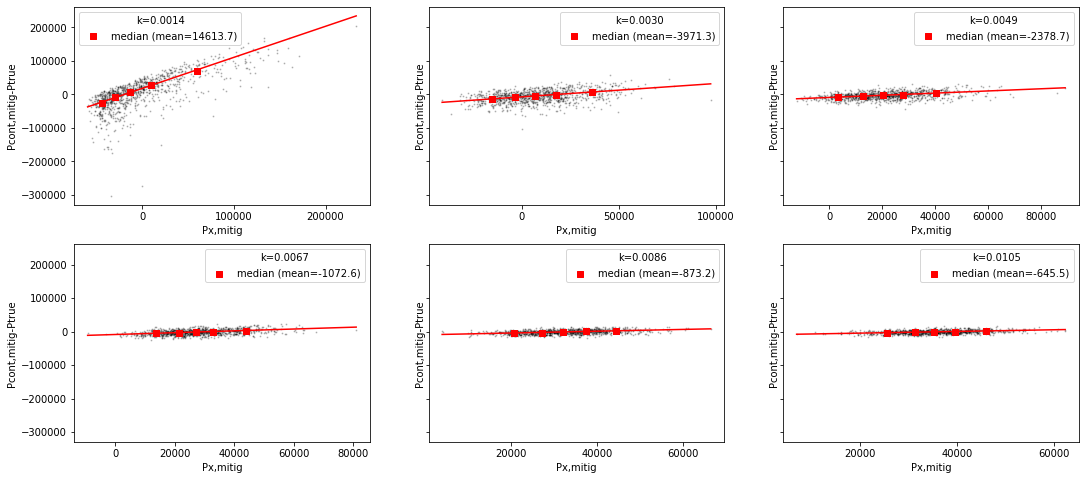

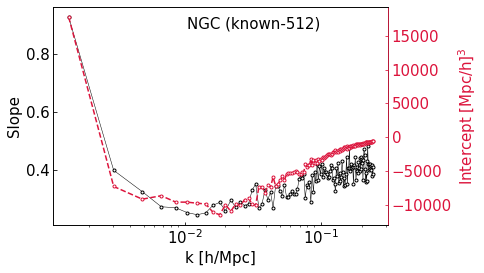

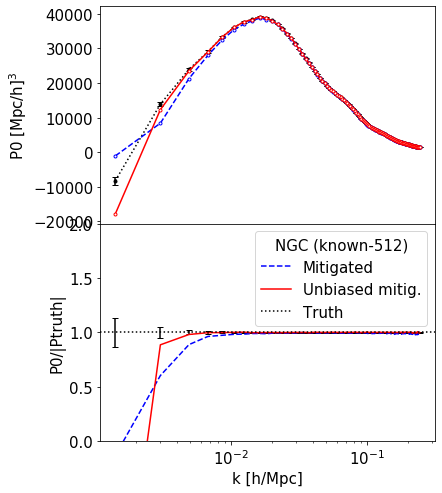

In [6]:
ngc0 = Spectra(cap='NGC', nside='512')
ngc0.load('known', '1')
ngc0.get_params(plot=True)

  1%|          | 1/128 [00:00<00:28,  4.53it/s]

0.0014085807875494757 -0.8583716565983551 -10544.547016180772


  2%|▏         | 2/128 [00:00<00:27,  4.52it/s]

0.0030163614591330397 -0.4132315168609339 -768.5757472052852


  2%|▏         | 3/128 [00:00<00:27,  4.48it/s]

0.0048942687912127796 -0.2787485301142734 3230.327699732783


  3%|▎         | 4/128 [00:00<00:28,  4.35it/s]

0.006745221186903896 -0.22284883075736545 5064.150510393112


  4%|▍         | 5/128 [00:01<00:28,  4.28it/s]

0.008613807931576003 -0.18479222914451537 5095.779228059055


  5%|▍         | 6/128 [00:01<00:28,  4.23it/s]

0.01049533751540886 -0.23642206997979676 7892.236577616721


100%|██████████| 128/128 [00:27<00:00,  4.66it/s]


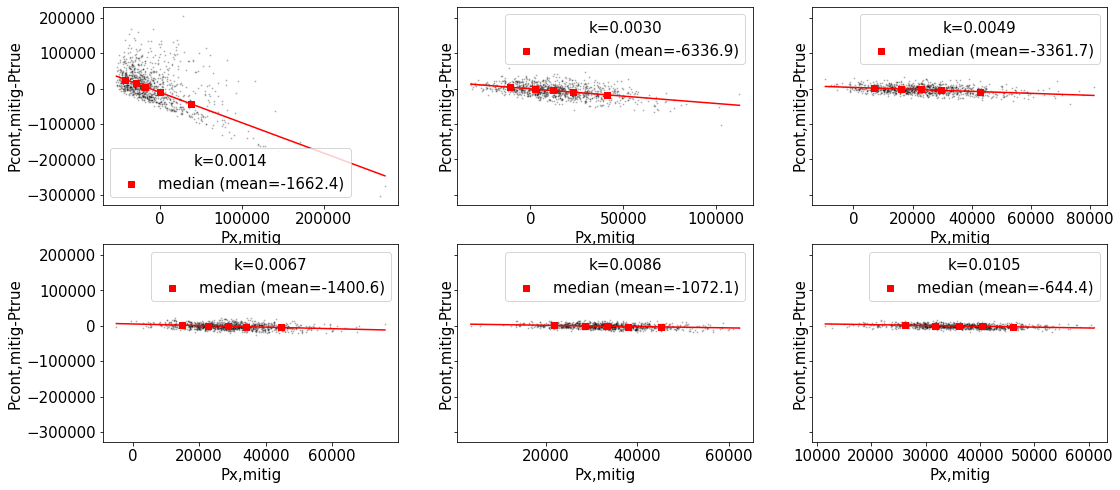

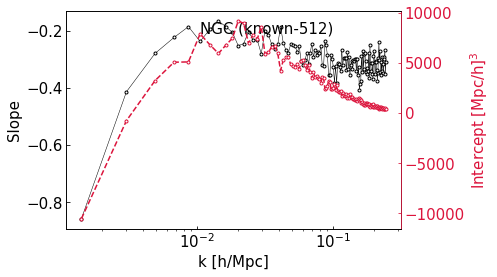

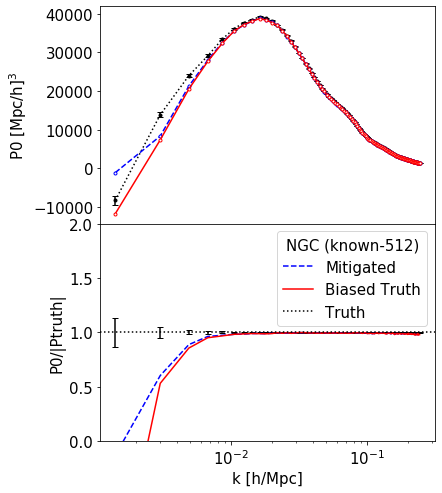

In [7]:
ngc1 = Spectra(cap='NGC', nside='512')
ngc1.load('known', '1')
ngc1.get_params(saveto='/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/pk_params_NGC_512_known_4model.txt', vs=0, plot=True)

  1%|          | 1/128 [00:00<00:29,  4.32it/s]

0.0014085807875494757 -0.4256680709099423 9343.195340359534


  2%|▏         | 2/128 [00:00<00:29,  4.33it/s]

0.0030163614591330397 -0.49934422161694675 3523.404547260467


  2%|▏         | 3/128 [00:00<00:28,  4.33it/s]

0.0048942687912127796 -0.4211272907124441 5558.207859653654


  3%|▎         | 4/128 [00:00<00:28,  4.34it/s]

0.006745221186903896 -0.4005379959954143 8892.72430840968


  4%|▍         | 5/128 [00:01<00:28,  4.34it/s]

0.008613807931576003 -0.4161430548990863 12036.13933191754


  5%|▍         | 6/128 [00:01<00:28,  4.35it/s]

0.01049533751540886 -0.3541410750146025 11343.348941663777


100%|██████████| 128/128 [00:26<00:00,  4.78it/s]


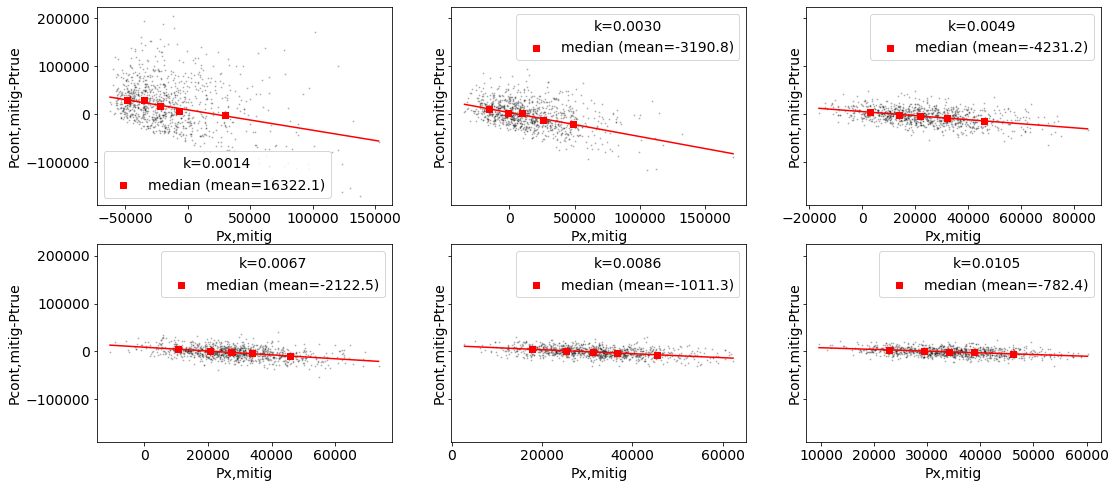

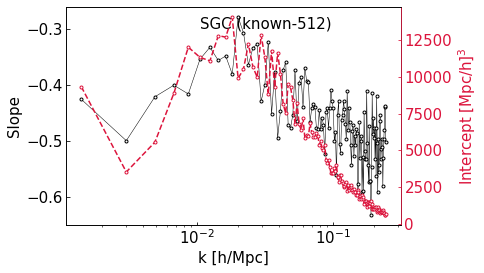

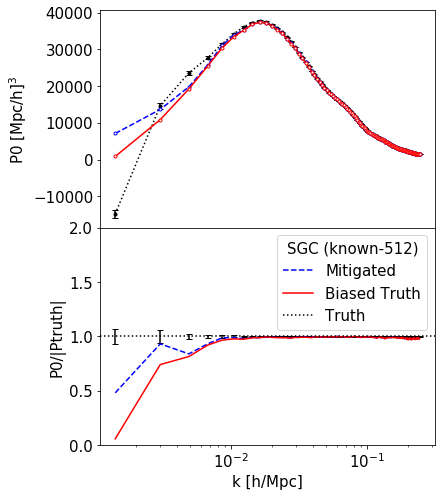

In [36]:
ngc1 = Spectra(cap='SGC', nside='512')
ngc1.load('known', '1')
ngc1.get_params(saveto='/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/pk_params_SGC_512_known_4model.txt', vs=0, plot=True)

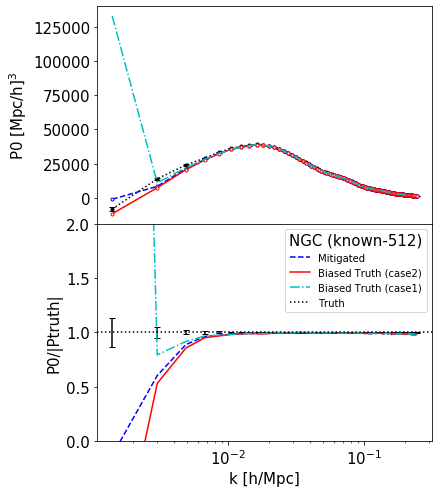

In [13]:
good = ngc0.k > 0.0#015 # ignore the first k bin
Ptrue_ = ngc0.pks[:,0,good]
pk_err = np.std(Ptrue_, axis=0) / np.sqrt(ngc0.nmocks)
Ptrue_mean = Ptrue_.mean(axis=0)
       

Pmitig_mean = ngc0.pks[:,1,good].mean(axis=0)
Ptrue_bias = (Ptrue_ + np.array(ngc0.bs)[good]) / (1-np.array(ngc0.ms)[good])
Ptrue_bias2 = (1 + np.array(ngc1.ms)[good])*Ptrue_ + np.array(ngc1.bs)[good]

fig, ax = plt.subplots(nrows=2, figsize=(6, 8), sharex=True)
fig.subplots_adjust(hspace=0.0)

ax[0].errorbar(ngc0.k[good], Ptrue_mean, pk_err, marker='.', 
               ls=':', color='k', capsize=3, zorder=-10)
ax[0].plot(ngc0.k[good], Pmitig_mean, '.b--',
           ngc0.k[good], Ptrue_bias2.mean(axis=0), '.r-',
           ngc0.k[good], Ptrue_bias.mean(axis=0), 'c-.', mfc='w')
ax[0].set(xscale='log', ylabel=r'P0 [Mpc/h]$^{3}$')


ax[1].plot(ngc0.k[good], Pmitig_mean/abs(Ptrue_mean), 'b--',
           ngc0.k[good], Ptrue_bias2.mean(axis=0)/abs(Ptrue_mean), 'r-',
          ngc0.k[good], Ptrue_bias.mean(axis=0)/abs(Ptrue_mean), 'c-.')
ax[1].axhline(1.0, ls=':', color='k')
ax[1].legend(['Mitigated', 'Biased Truth (case2)', 'Biased Truth (case1)', 'Truth'],
            title=f'{ngc0.cap} ({ngc0.method}-{ngc0.nside})', fontsize=10)

ax[1].errorbar(ngc0.k[good], np.ones(good.size), pk_err/abs(Ptrue_mean), ls='None', color='k', capsize=3, zorder=-10)
ax[1].set(xscale='log', xlabel='k [h/Mpc]', ylabel=r'P0/|Ptruth|', ylim=(0.0, 2.0)) 
fig.savefig('p0mock_bias.png', dpi=300, bbox_inches='tight')

In [26]:
from compute_pk_mean_cov import get_covmax_wcorrect, get_covmax

In [25]:
params = np.loadtxt('/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/pk_params_NGC_512_known.txt')
covm = get_covmax_wcorrect('NGC', '1', 'known', '512', params[:, 1], params[:, 2])
np.savez('./debiased_covpk_ezmocks_ngc_cont_known_512_v1.0', **covm)

1000


In [27]:
cov0 = get_covmax('NGC', '1', 'known', '512')

1000


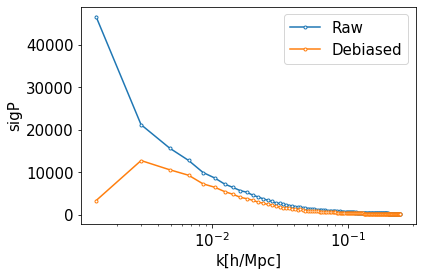

In [33]:
for covi in [cov0, covm]:
    plt.plot(covi['k'], np.sqrt(np.diagonal(covi['covp0'])), '.-', mfc='w')
plt.xscale('log')
plt.xlabel('k[h/Mpc]')
plt.ylabel('sigP')
plt.legend(['Raw', 'Debiased'])

In [34]:
cov_old = np.load('./covpk_ezmocks_ngcsgc_v1.0.npz', allow_pickle=True)

In [39]:
abs(cov_old['NGC_cont_nnknown_512'].item()['covp0'] - cov0['covp0']).max()

0.0

In [42]:
covm

{'k': array([0.00140858, 0.00301636, 0.00489427, 0.00674522, 0.00861381,
        0.01049534, 0.01240988, 0.01431138, 0.01620877, 0.01810703,
        0.02000224, 0.02190381, 0.02381228, 0.02572243, 0.02763036,
        0.02952432, 0.03142427, 0.03332888, 0.03522832, 0.0371289 ,
        0.03903652, 0.04094381, 0.04284799, 0.04474728, 0.04664888,
        0.04855795, 0.05046789, 0.05237002, 0.0542632 , 0.05616317,
        0.05807051, 0.05998014, 0.0618902 , 0.06378963, 0.06568876,
        0.06759027, 0.06949796, 0.07140779, 0.07330911, 0.0752074 ,
        0.07710805, 0.07901509, 0.0809228 , 0.08282665, 0.08473248,
        0.08663543, 0.08853676, 0.09044033, 0.09234391, 0.09424788,
        0.0961537 , 0.0980583 , 0.09996051, 0.10186646, 0.10377099,
        0.1056728 , 0.10757676, 0.10948202, 0.1113865 , 0.11328763,
        0.11519007, 0.11709687, 0.11900545, 0.12090671, 0.12280603,
        0.1247111 , 0.1266185 , 0.1285218 , 0.13042295, 0.13232639,
        0.13422943, 0.13613479, 0.13804145,

In [44]:
cov_old['NGC_cont_nnknown_512'].item()

{'k': array([0.00140858, 0.00301636, 0.00489427, 0.00674522, 0.00861381,
        0.01049534, 0.01240988, 0.01431138, 0.01620877, 0.01810703,
        0.02000224, 0.02190381, 0.02381228, 0.02572243, 0.02763036,
        0.02952432, 0.03142427, 0.03332888, 0.03522832, 0.0371289 ,
        0.03903652, 0.04094381, 0.04284799, 0.04474728, 0.04664888,
        0.04855795, 0.05046789, 0.05237002, 0.0542632 , 0.05616317,
        0.05807051, 0.05998014, 0.0618902 , 0.06378963, 0.06568876,
        0.06759027, 0.06949796, 0.07140779, 0.07330911, 0.0752074 ,
        0.07710805, 0.07901509, 0.0809228 , 0.08282665, 0.08473248,
        0.08663543, 0.08853676, 0.09044033, 0.09234391, 0.09424788,
        0.0961537 , 0.0980583 , 0.09996051, 0.10186646, 0.10377099,
        0.1056728 , 0.10757676, 0.10948202, 0.1113865 , 0.11328763,
        0.11519007, 0.11709687, 0.11900545, 0.12090671, 0.12280603,
        0.1247111 , 0.1266185 , 0.1285218 , 0.13042295, 0.13232639,
        0.13422943, 0.13613479, 0.13804145,

In [41]:
params[:5]

array([[ 1.40858000e-03,  9.28418740e-01,  1.77641961e+04],
       [ 3.01636000e-03,  3.98115710e-01, -7.26012409e+03],
       [ 4.89427000e-03,  3.24357280e-01, -9.13788024e+03],
       [ 6.74522000e-03,  2.72156520e-01, -8.63216309e+03],
       [ 8.61381000e-03,  2.68434700e-01, -9.57054447e+03]])

In [ ]:
ngc1 = Spectra(cap='NGC', nside='512')
ngc1.load('known', '1')

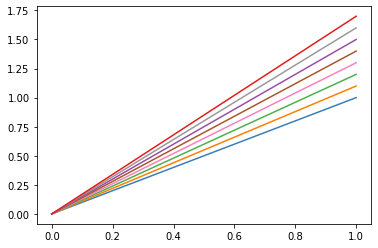

In [19]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c']

for i, c in enumerate(colors):
    plt.plot([0, 1], [0, 1+i*0.1], color=c)

In [93]:
plt.rc('font', size=15)

0.0014085807875494757 -0.8583716565983551 -10544.547016180772
0.0030163614591330397 -0.4132315168609339 -768.5757472052852
0.0048942687912127796 -0.2787485301142734 3230.327699732783
0.006745221186903896 -0.22284883075736545 5064.150510393112


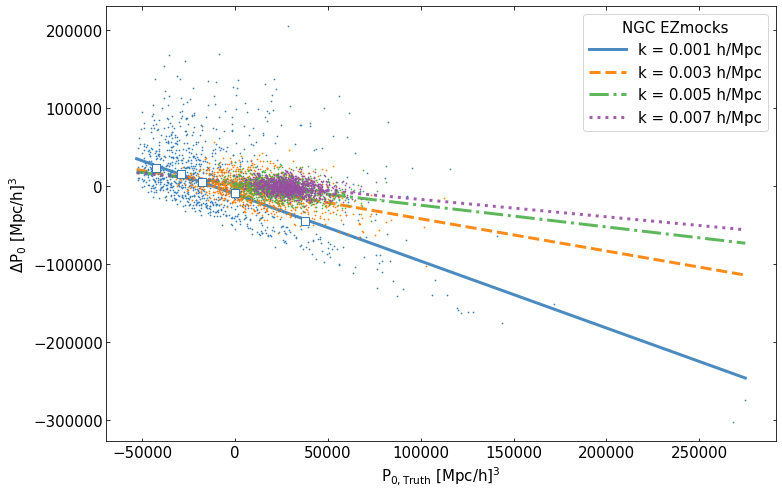

In [125]:
fig, ax = plt.subplots(figsize=(12, 8))

vs = 0

colors = ['#377eb8', '#ff7f00', '#4daf4a',
         '#984ea3', '#a65628', '#f781bf',
          '#999999', '#e41a1c']
ls = ['-', '--', '-.', ':']

x_plot = None

for j in [0, 1, 2, 3]:
    
    color = colors[j]
    
    bins_p = np.percentile(ngc1.pks[:, vs, j], [0, 20, 40, 60, 80, 100])
    bins_p[-1] += 1.0e-4
    if x_plot is None:
        x_plot = bins_p
        
    ix = np.digitize(ngc1.pks[:, vs, j], bins=bins_p)
    
    x_ = []
    y_ = []
    for i in ix:
        s_i = ix == i
        x_.append(np.median(ngc1.pks[s_i, vs, j], axis=0))
        y_.append(np.median(ngc1.pks[s_i, 2, j], axis=0))

    x_ = np.array(x_)
    y_ = np.array(y_)

    m,b  = solve(x_, y_)            


    ax.scatter(ngc1.pks[:, vs, j], ngc1.pks[:, 2, j], 2, marker='.', alpha=1., color=color, zorder=-10+j)
    if j == 0:
        ax.scatter(x_, y_, 50, marker='s', fc='w', color=color, zorder=10)
        
    ax.plot(x_plot, m*x_plot + b, ls=ls[j], color=color, lw=3., alpha=.9, label=f'k = {ngc1.k[j]:.3f} h/Mpc', zorder=-20+j)
    print(ngc1.k[j], m, b) 


ax.set(xlabel=r'P$_{0, {\rm Truth}}$ [Mpc/h]$^{3}$', 
       ylabel=r'$\Delta$P$_{0}$ [Mpc/h]$^{3}$')#ylim=(0., 10),
ax.legend(fontsize=15, handlelength=2.5, title='NGC EZmocks')
ax.tick_params(direction='in', which='both', top=True, right=True)

  1%|          | 1/128 [00:00<00:27,  4.69it/s]

0.0014085807875494757 0.9284187432992339 17764.19612486808


  2%|▏         | 2/128 [00:00<00:26,  4.71it/s]

0.0030163614591330397 0.39811570964157167 -7260.124091653844


  2%|▏         | 3/128 [00:00<00:30,  4.17it/s]

0.0048942687912127796 0.32435727819723975 -9137.880238897467


  3%|▎         | 4/128 [00:00<00:28,  4.32it/s]

0.006745221186903896 0.272156523077944 -8632.163090473441


  4%|▍         | 5/128 [00:01<00:27,  4.44it/s]

0.008613807931576003 0.26843470408263254 -9570.54447192081


  5%|▌         | 7/128 [00:01<00:25,  4.66it/s]

0.01049533751540886 0.2515861507861507 -9582.635725758548


100%|██████████| 128/128 [00:26<00:00,  4.92it/s]


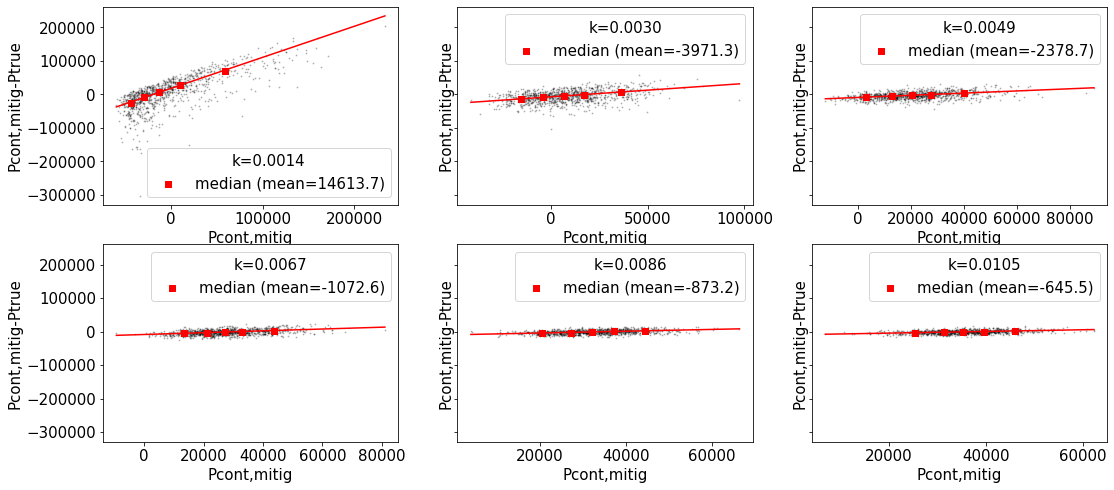

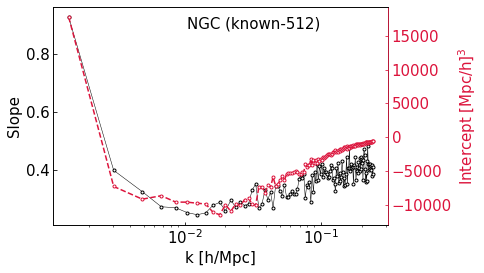

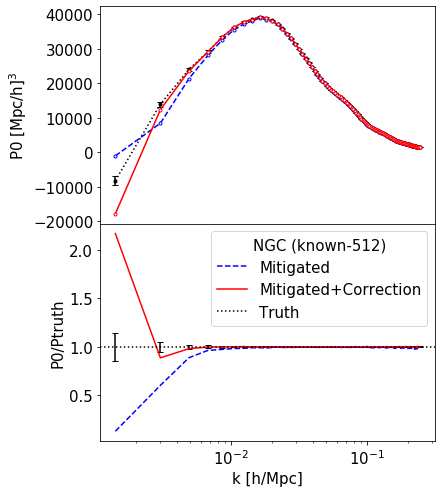

In [3]:
ngc1 = Spectra(cap='NGC', nside='512')
ngc1.load('known', '1')
ngc1.get_params(plot=True)

  1%|          | 1/128 [00:00<00:26,  4.75it/s]

0.0014085807875494757 0.1281297194083447 -5872.149156506104


  2%|▏         | 2/128 [00:00<00:26,  4.72it/s]

0.0030163614591330397 0.036873878283517986 -10221.547201682766


  2%|▏         | 3/128 [00:00<00:26,  4.73it/s]

0.0048942687912127796 0.0328070527410224 -5418.121918894255


  3%|▎         | 4/128 [00:00<00:27,  4.55it/s]

0.006745221186903896 0.033046718291791725 -3336.981214233736


  4%|▍         | 5/128 [00:01<00:27,  4.44it/s]

0.008613807931576003 0.07927871226167107 -3746.877240519272


  5%|▍         | 6/128 [00:01<00:28,  4.35it/s]

0.01049533751540886 0.07351803588223785 -3438.587756720875


100%|██████████| 128/128 [00:26<00:00,  4.76it/s]


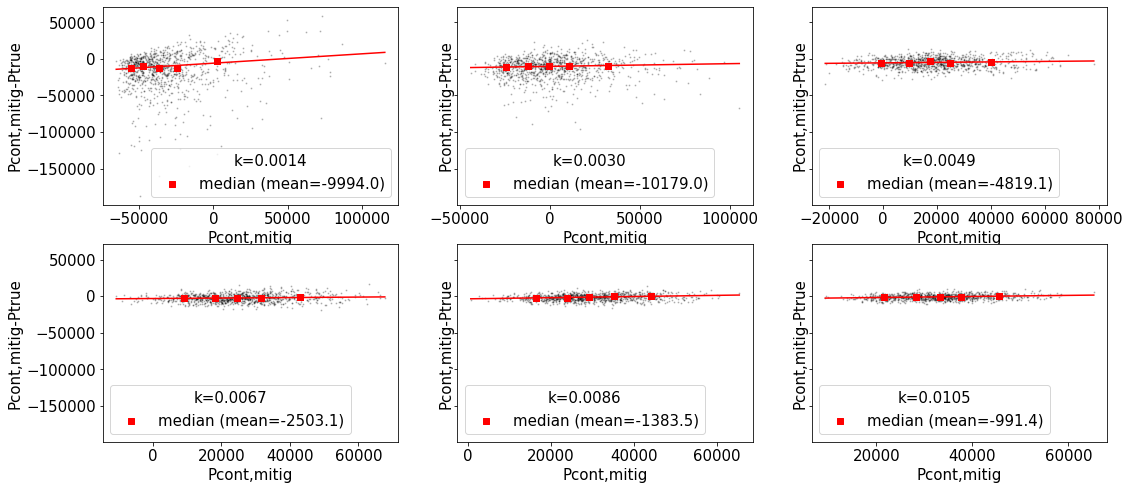

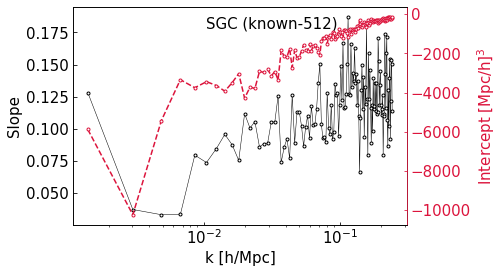

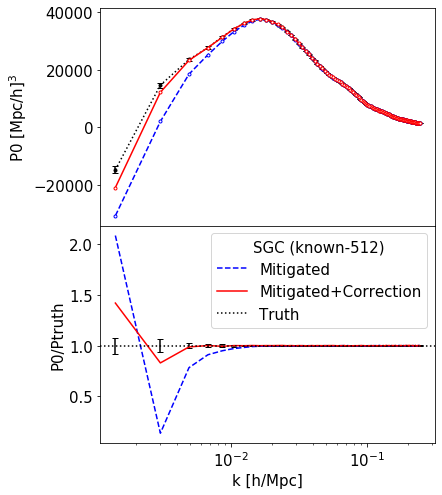

In [4]:
sgc0 = Spectra(cap='SGC', nside='512')
sgc0.load('known', '0')
sgc0.get_params(plot=True)

  1%|          | 1/128 [00:00<00:29,  4.24it/s]

0.0014085807875494757 0.7979592828781384 23547.926995664973


  2%|▏         | 2/128 [00:00<00:30,  4.13it/s]

0.0030163614591330397 0.5810160572706912 -5984.077125310543


  2%|▏         | 3/128 [00:00<00:30,  4.09it/s]

0.0048942687912127796 0.4738804529317088 -11665.710428229426


  3%|▎         | 4/128 [00:00<00:30,  4.12it/s]

0.006745221186903896 0.41532646599587664 -12116.82209357433


  4%|▍         | 5/128 [00:01<00:29,  4.16it/s]

0.008613807931576003 0.44813306528478 -14295.185229571574


  5%|▍         | 6/128 [00:01<00:29,  4.17it/s]

0.01049533751540886 0.4610551545751473 -15913.669338368889


100%|██████████| 128/128 [00:33<00:00,  3.79it/s]


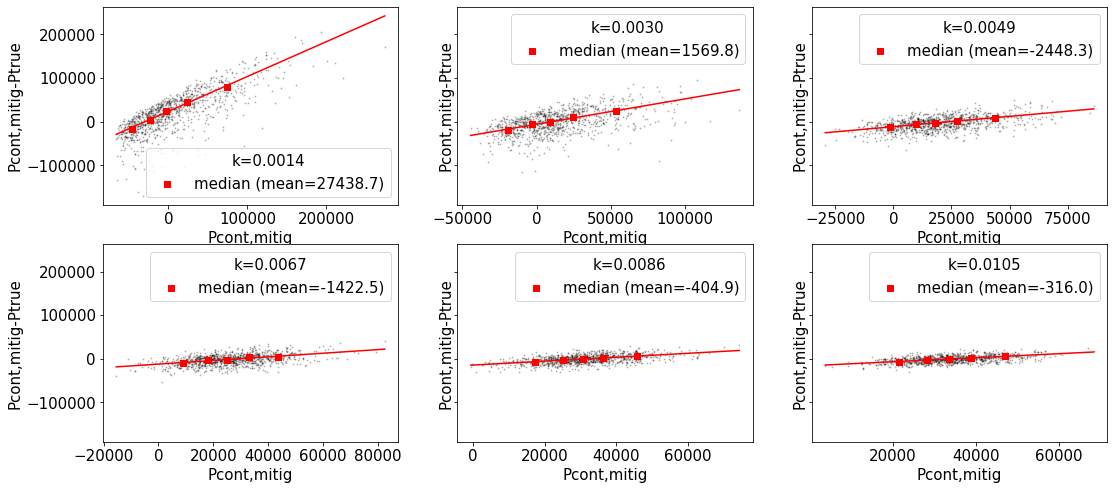

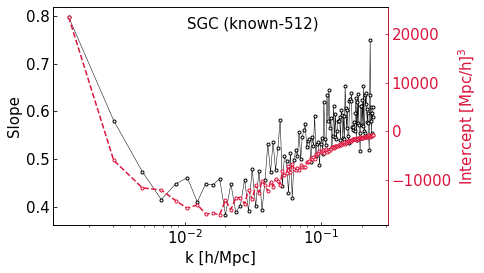

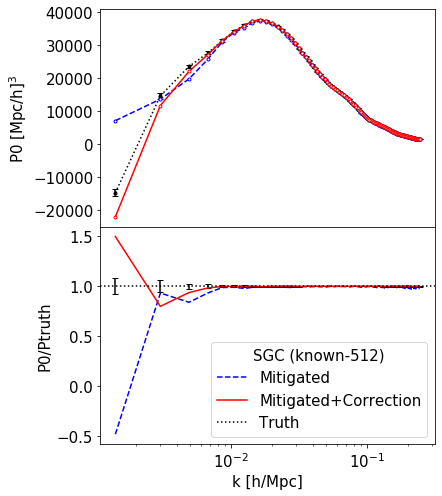

In [5]:
sgc1 = Spectra(cap='SGC', nside='512')
sgc1.load('known', '1')
sgc1.get_params(plot=True)

In [6]:
def plot(k_, pk_, label=None, marker='.', **kw):
    #pkmin, pkmax = np.percentile(pk_, [15.8, 84.2], axis=0)
    #plt.fill_between(k_, pkmin, pkmax, alpha=0.3)
    for i in np.random.choice(np.arange(pk_.shape[0]), replace=False, size=100):
        plt.plot(k_, pk_[i, :], **kw, lw=0.5, alpha=0.1)
        
    l, = plt.plot(k_, pk_.mean(axis=0),
                 marker=marker, mfc='w', label=label, **kw)
    #l.set_markerfacecolor((1, 1, 1, 0.5))

In [24]:
ngc1 = Spectra()
ngc1.load('known', '1')
ngc2 = Spectra()
ngc2.load('noweight', '1')

sgc1 = Spectra('SGC')
sgc1.load('known', '1')
sgc2 = Spectra('SGC')
sgc2.load('noweight', '1')

100%|██████████| 999/999 [00:03<00:00, 289.96it/s]


Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

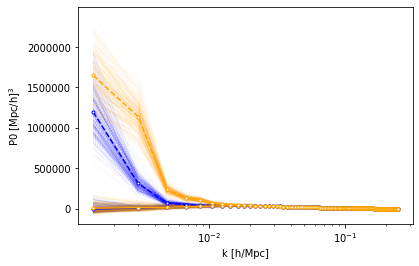

In [4]:
plot(ngc1.k, ngc1.pks[:, 0, :], ls='-', color='b')
plot(ngc2.k, ngc2.pks[:, 0, :], ls='--', color='b')

plot(sgc1.k, sgc1.pks[:, 0, :], ls='-', color='orange')
plot(sgc2.k, sgc2.pks[:, 0, :], ls='--', color='orange')
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
# plt.yscale('log')

Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

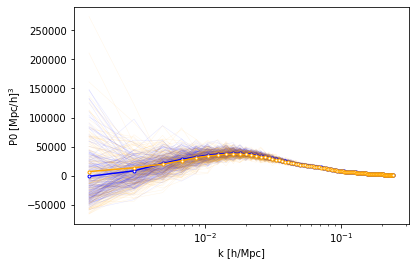

In [5]:
plot(ngc1.k, ngc1.pks[:, 0, :], ls='-', color='b')
# plot(ngc2.k, ngc2.pks[:, 0, :], ls='--', color='b')

plot(sgc1.k, sgc1.pks[:, 0, :], ls='-', color='orange')
# plot(sgc2.k, sgc2.pks[:, 0, :], ls='--', color='orange')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')

Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

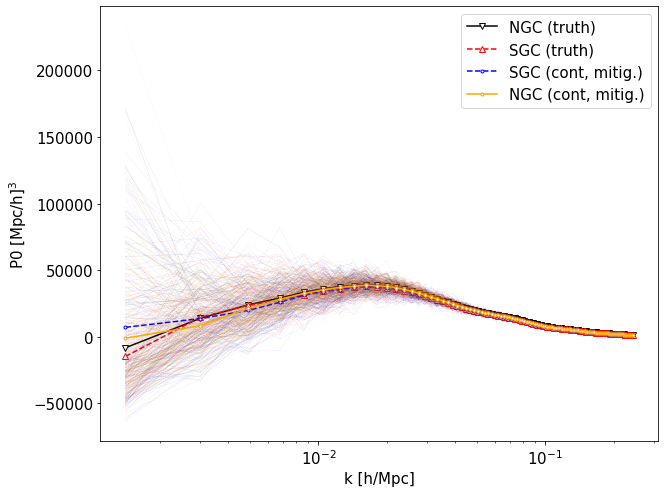

In [46]:
plt.figure(figsize=(10, 8))

plot(ngc1.k, ngc1.pks[:, 0, :]-ngc1.pks[:, 1, :], marker='v', label='NGC (truth)', ls='-', color='k')
plot(sgc1.k, sgc1.pks[:, 0, :]-sgc1.pks[:, 1, :], marker='^', label='SGC (truth)', ls='--', color='red')

plot(sgc1.k, sgc1.pks[:, 0, :], marker='.', label='SGC (cont, mitig.)', ls='--', color='blue')
plot(ngc1.k, ngc1.pks[:, 0, :], marker='.', label='NGC (cont, mitig.)', ls='-', color='orange')

plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')

In [7]:
ngc1 = Spectra()
ngc1.load('known', '1')
ngc2 = Spectra()
ngc2.load('known', '0')

sgc1 = Spectra('SGC')
sgc1.load('known', '1')
sgc2 = Spectra('SGC')
sgc2.load('known', '0')

100%|██████████| 999/999 [00:03<00:00, 298.82it/s]


Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

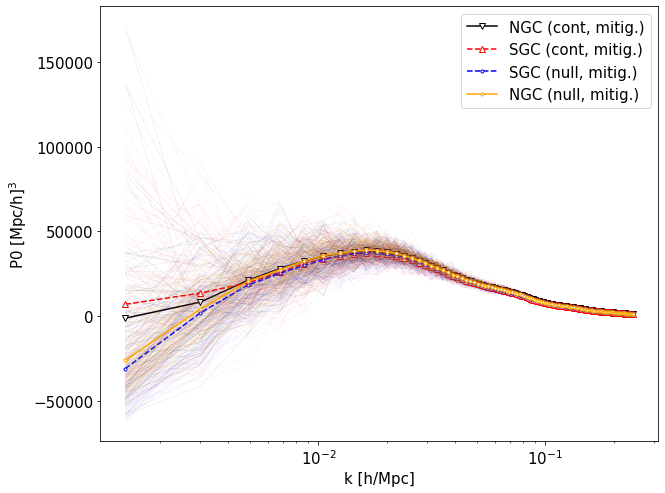

In [8]:
plt.figure(figsize=(10, 8))

plot(ngc1.k, ngc1.pks[:, 0, :], marker='v', label='NGC (cont, mitig.)', ls='-', color='k')
plot(sgc1.k, sgc1.pks[:, 0, :], marker='^', label='SGC (cont, mitig.)', ls='--', color='red')

plot(sgc2.k, sgc2.pks[:, 0, :], marker='.', label='SGC (null, mitig.)', ls='--', color='blue')
plot(ngc2.k, ngc2.pks[:, 0, :], marker='.', label='NGC (null, mitig.)', ls='-', color='orange')

plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')

In [8]:
ngc1 = Spectra()
ngc1.load('known', '0')

sgc1 = Spectra('SGC')
sgc1.load('known', '0')

100%|██████████| 999/999 [00:06<00:00, 150.40it/s]


In [19]:
plt.rc('font', size=15)

Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

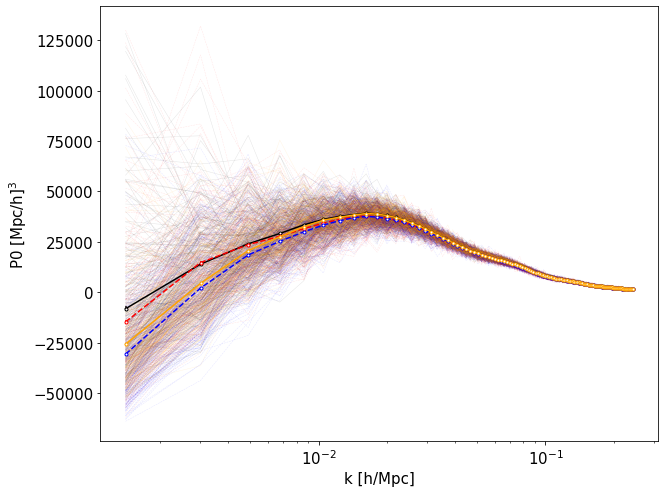

In [23]:
plt.figure(figsize=(10, 8))

plot(ngc1.k, ngc1.pks[:, 0, :]-ngc1.pks[:, 1, :], ls='-', color='k')
plot(sgc1.k, sgc1.pks[:, 0, :]-sgc1.pks[:, 1, :], ls='--', color='red')

plot(sgc1.k, sgc1.pks[:, 0, :], ls='--', color='blue')
plot(ngc1.k, ngc1.pks[:, 0, :], ls='-', color='orange')


plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')

Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

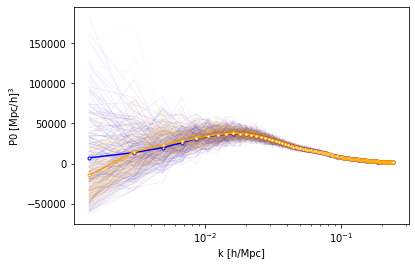

In [7]:
plot(sgc1.k, sgc1.pks[:, 0, :], ls='-', color='b')
plot(sgc1.k, sgc1.pks[:, 0, :]-sgc1.pks[:, 1, :], ls='-', color='orange')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')

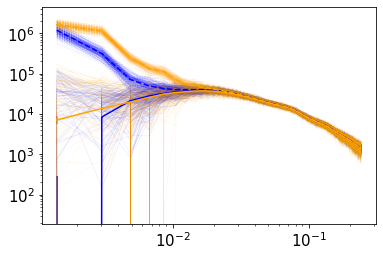

In [10]:
plot(ngc1.k, ngc1.pks[:, 0, :], ls='-', color='b')
plot(ngc2.k, ngc2.pks[:, 0, :], ls='--', color='b')

plot(sgc1.k, sgc1.pks[:, 0, :], ls='-', color='orange')
plot(sgc2.k, sgc2.pks[:, 0, :], ls='--', color='orange')
plt.xscale('log')
plt.yscale('log')

In [5]:
path = '/home/mehdi/data/eboss/mocks/1.0/measurements/spectra/'
pkname_fn = lambda p, c, m, n, i, ix:f'{p}spectra_{c}_{m}_mainhighz_{n}_v7_{i}_{ix:04d}_main.json'    
    
def solve(x, y):
    n = len(x)
    sumy = np.sum(y)
    sumx = np.sum(x)
    sumx2 = np.sum(x*x)
    sumxy = np.sum(x*y)

    b = (sumy*sumx2-sumx*sumxy)/(n*sumx2-sumx*sumx)
    m = (n*sumxy - sumx*sumy)/(n*sumx2-sumx*sumx)
    return m, b

def readpk(*params):
    filename = pkname_fn(*params)
    d = nb.ConvolvedFFTPower.load(filename)
    return (d.poles['k'], d.poles['power_0'].real - d.attrs['shotnoise']) # 

class Spectra:
    
    def __init__(self, cap='NGC', nside='512'):    
        self.cap = cap
        self.nmocks = 1000 if cap=='NGC' else 999
        self.nside = nside

        
    def load(self, method, iscont):        
        pks = []
        for ix in tqdm(range(1, self.nmocks+1)):
            k0, p0 = readpk(path, self.cap, 'knownsystot', self.nside, '0', ix)
            k1, p1 = readpk(path, self.cap,  method, self.nside, iscont, ix)
            pks.append([p1, p1-p0])

        assert np.array_equal(k0, k1)
        self.k = k0
        self.pks = np.array(pks)
        self.method = method
    
    def get_params(self, saveto=None, plot=False):
        self.ms = []
        self.bs = []
        
        fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), sharey=True)
        ax = ax.flatten()
        
        for j in tqdm(range(self.pks.shape[2])):
            bins_p = np.percentile(self.pks[:, 0, j], [0, 20, 40, 60, 80, 100])
            bins_p[-1] += 1.0e-4
            ix = np.digitize(self.pks[:, 0, j], bins=bins_p)
            x_ = []
            y_ = []
            for i in ix:
                s_i = ix == i
                x_.append(np.median(self.pks[s_i, 0, j], axis=0))
                y_.append(np.median(self.pks[s_i, 1, j], axis=0))

            x_ = np.array(x_)
            y_ = np.array(y_)

            m,b  = solve(x_, y_)

            self.ms.append(m)
            self.bs.append(b)
            
            if j < 6:    
                ax[j].scatter(self.pks[:, 0, j], self.pks[:, 1, j], 1.0, color='k', alpha=0.2)
                ax[j].scatter(x_, y_, label=f'median (mean=%.1f)'%np.mean(y_), marker='s', color='r')
                ax[j].plot(bins_p, m*bins_p + b, 'r-')
                print(self.k[j], m, b) 

                #ax[j].set(ylim=(0., 4), xlabel=xlabel[vs], ylabel='Pcont,mitig/Ptrue')
                ax[j].set(xlabel='Pcont,mitig', ylabel='Pcont,mitig-Ptrue')#ylim=(0., 10),
                ax[j].legend(title=f'k={self.k[j]:.4f}')
            
        if saveto is not None:
            np.savetxt(saveto, np.column_stack([self.k, self.ms, self.bs]), 
                       header=f"kavg, slope, intercept [Mpc/h]**3 ({self.cap}, {self.nside}, {self.method})",
                                                        fmt='%.8f')
            
        if plot:
            plt.rc('font', size=15)
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()

            ax1.plot(self.k, self.ms, 'k-', marker='.', mfc='w', lw=0.5)
            ax2.plot(self.k, self.bs, '--', color='crimson', marker='.', mfc='w', )


            ax1.set_ylabel(r'Slope')
            ax1.text(0.4, 0.9, f'{self.cap} ({self.method}-{self.nside})', transform=ax1.transAxes)
            ax1.tick_params(axis='both', direction='in')
            ax1.set_xlabel('k [h/Mpc]')
            ax1.set_ylim(ymin=0.0)

            ax2.set_ylabel(r'Intercept [Mpc/h]$^{3}$', color='crimson')
            ax2.tick_params(axis='y', direction='in', colors='crimson', which='both')
            ax2.spines['right'].set_color('crimson')
            ax2.set_xscale('log') 
            if saveto is not None:
                fig.savefig(saveto.replace('.txt', '.png'), dpi=300, bbox_inches='tight')



    
# class Fitter:
    
#     def __init__(self, k, dp):
#         self.k = k
#         self.dp = dp

#     def model(self, a, k, p=None):
#         k2 = k*k
#         C = a[0] + a[1]/k + a[2]/k2        
#         return C
        
#     def loss(self, params, k, dp):
#         """ Loss Function """
#         res = (dp - self.model(params, k))                   
#         ssr = (res*res).mean()
#         return ssr
    
#     def minimize(self, guess=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]):
# #         print('{:8s}:'.format(''), end=' ')
# #         for xi in guess:
# #             print(f'{xi:12.4f}', end=' ')
# #         print('')        
#         self.result = minimize(self.loss, guess, args=(self.k, self.dp))   
        
#     def unbias(self, k, pk):
#         return pk-self.model(ft.result.x, k)        
        
#     def plot(self):
#         k_ = np.linspace(self.k.min(), self.k.max(), 500)
        
#         plt.scatter(self.k, self.dp, marker='o', label='Measured', alpha=0.5)
#         plt.plot(k_, self.model(self.result.x, k_), '--', label='Model')
#         plt.ylabel(r'$\Delta$P [Mpc/h]$^{3}$')
#         plt.xlabel('k [h/Mpc]')
#         plt.legend()
#         plt.xscale('log')

## read spectra

In [7]:
sp = Spectra(cap='NGC', nside='512')
sp.load('known', '0')

0.0014085807875494757 -0.0793004490470907 -14656.055548114578
0.0030163614591330397 0.019893584916976043 -7966.612464049481
0.0048942687912127796 0.03827791996611197 -4065.6705971293095
0.006745221186903896 0.03961565695057739 -2791.0570018631347
0.008613807931576003 0.03889651500285266 -2187.2354629354863
0.01049533751540886 0.05615675250551707 -2432.0932086216585



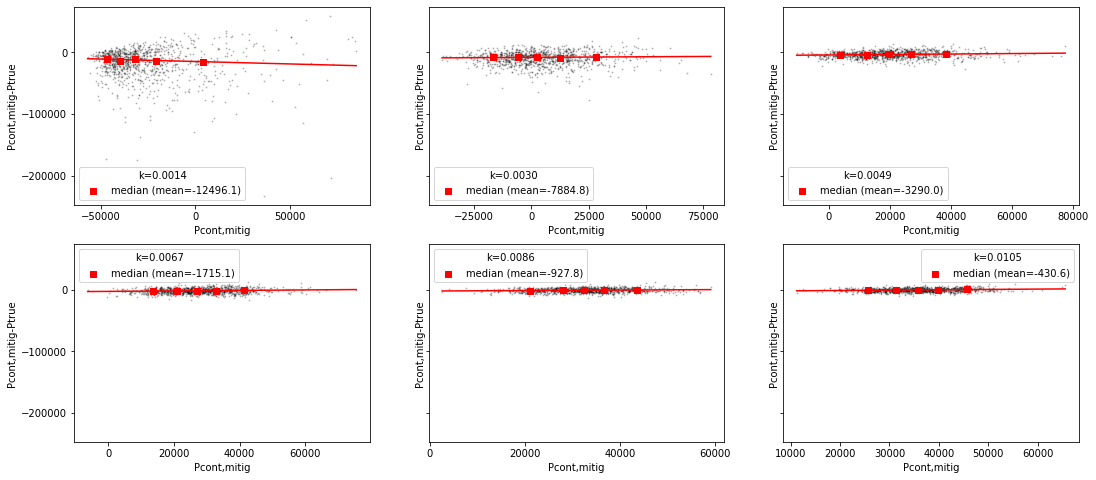

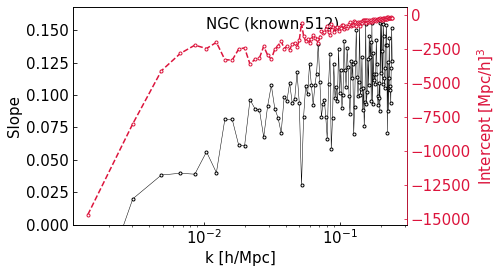

In [8]:
sp.get_params(plot=True)

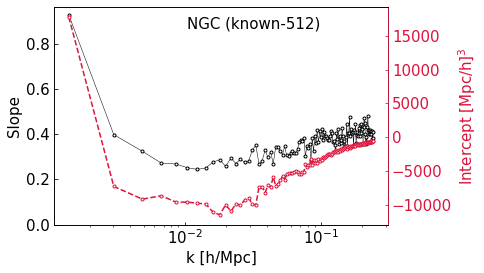

In [32]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(sp.k, sp.ms, 'k-', marker='.', mfc='w', lw=0.5)
ax2.plot(sp.k, sp.bs, '--', color='crimson', marker='.', mfc='w', )


ax1.set_ylabel(r'Slope')
ax1.text(0.4, 0.9, f'{sp.cap} ({sp.method}-{sp.nside})', transform=ax1.transAxes)
ax1.tick_params(axis='both', direction='in')
ax1.set_xlabel('k [h/Mpc]')
ax1.set_ylim(ymin=0.0)

ax2.set_ylabel(r'Intercept [Mpc/h]$^{3}$', color='crimson')
ax2.tick_params(axis='y', direction='in', colors='crimson', which='both')
ax2.spines['right'].set_color('crimson')
ax2.set_xscale('log')

[Text(0, 0.5, 'P0/Ptruth'), None, Text(0.5, 0, 'k [h/Mpc]')]

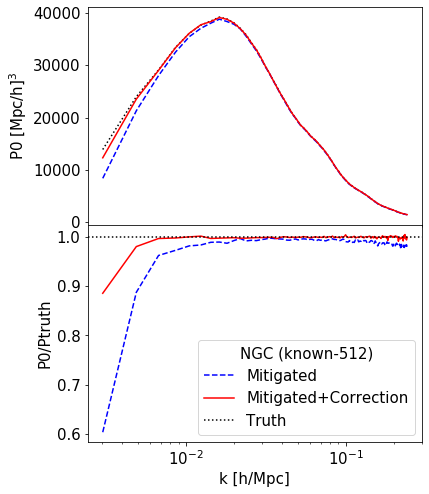

## Ratios

0.9284187432992339 17764.19612486808
0.39811570964157167 -7260.124091653844
0.32435727819723975 -9137.880238897467
0.272156523077944 -8632.163090473441
0.26843470408263254 -9570.54447192081
0.2515861507861507 -9582.635725758548



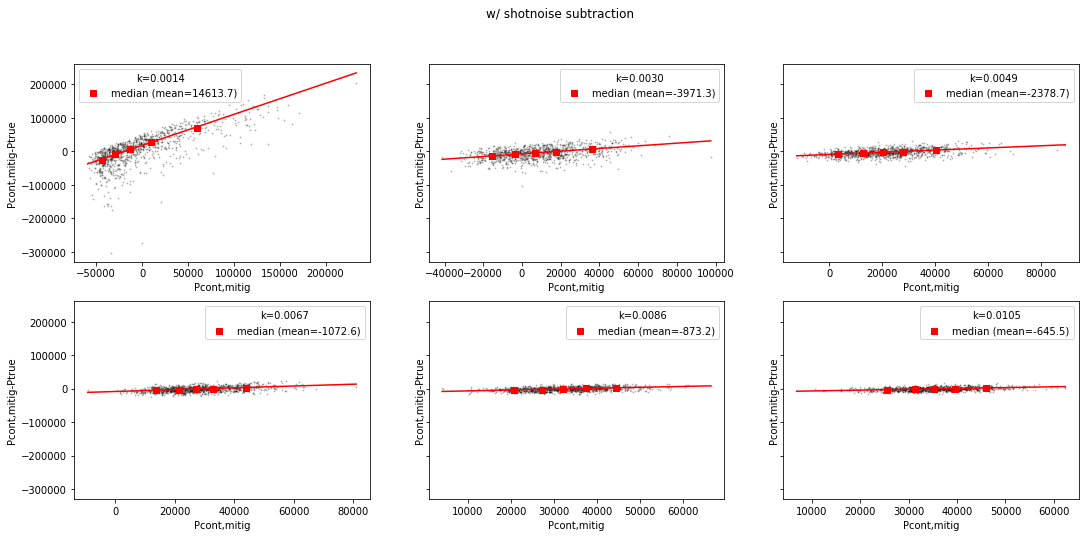

In [4]:
vs = 1

xlabel = {0:'Ptrue',
          1:'Pcont,mitig'}

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), sharey=True)
ax = ax.flatten()
fig.suptitle('w/ shotnoise subtraction')

ms = []
bs = []

for j in tqdm(range(pknn.shape[2])):

    bins_p = np.percentile(pknn[:, vs, j], [0, 20, 40, 60, 80, 100])
    bins_p[-1] += 1.0e-4
    ix = np.digitize(pknn[:, vs, j], bins=bins_p)
    x_ = []
    y_ = []
    for i in ix:
        s_i = ix == i
        x_.append(np.median(pknn[s_i, vs, j], axis=0))
        y_.append(np.median(pknn[s_i, 2, j], axis=0))

    x_ = np.array(x_)
    y_ = np.array(y_)
    
    m,b  = solve(x_, y_)
    
    ms.append(m)
    bs.append(b)
    
    if j < 6:    
        ax[j].scatter(pknn[:, vs, j], pknn[:, 2, j], 1.0, color='k', alpha=0.2)
        ax[j].scatter(x_, y_, label=f'median (mean=%.1f)'%np.mean(y_), marker='s', color='r')
        ax[j].plot(bins_p, m*bins_p + b, 'r-')
        print(m, b)

        #ax[j].set(ylim=(0., 4), xlabel=xlabel[vs], ylabel='Pcont,mitig/Ptrue')
        ax[j].set(xlabel=xlabel[vs], ylabel='Pcont,mitig-Ptrue')#ylim=(0., 10),
        ax[j].legend(title=f'k={k[j]:.4f}')

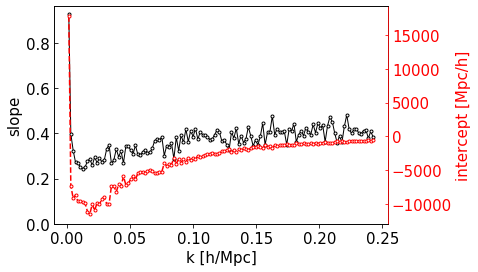

In [5]:
fontsize = 15

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(k, ms, 'k-', marker='.', mfc='w', lw=1)
ax2.plot(k, bs, 'r--', marker='.', mfc='w', )


ax1.set_ylabel(r'slope', fontsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize, direction='in')
ax1.tick_params(axis='x', labelsize=fontsize) # x- has a different color
ax1.set_xlabel('k [h/Mpc]', fontsize=fontsize)
ax1.set_ylim(ymin=0.0)

ax2.set_ylabel(r'intercept [Mpc/h]', fontsize=fontsize, color='r')
ax2.tick_params(axis='y', labelsize=fontsize, direction='in', colors='red', which='both')
ax2.spines['right'].set_color('red')
# ax2.set_xscale('log')

In [6]:
good = k > 0.0015

Ptrue_mean = pknn[:,0,good].mean(axis=0)
Pmitig_mean = pknn[:,1,good].mean(axis=0)

In [9]:
good.sum()

127

In [11]:
ms = np.array(ms)
bs = np.array(bs)

In [21]:
Pcorrec = (1-ms)*pknn[:, 1,:]-bs

Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

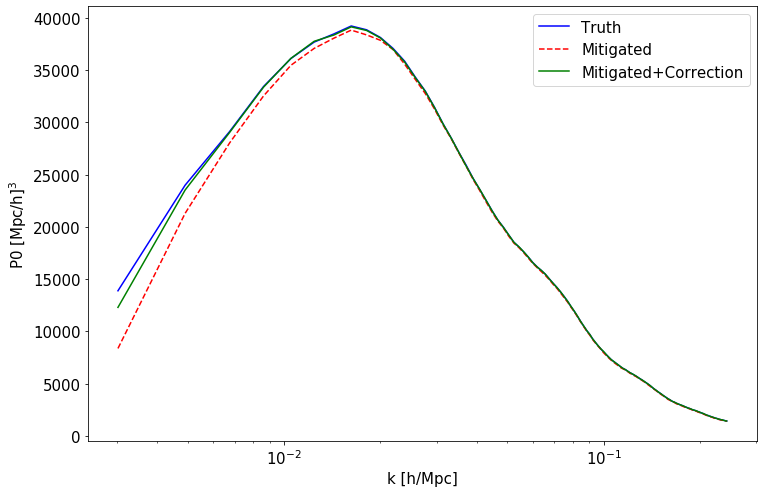

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(k[good], Ptrue_mean, 'b-',
        k[good], Pmitig_mean, 'r--',
        k[good], Pcorrec[:, good].mean(axis=0), 'g-')
plt.legend(['Truth', 'Mitigated', 'Mitigated+Correction'])
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
# plt.yscale('log')

Text(0, 0.5, 'P0/Ptruth')

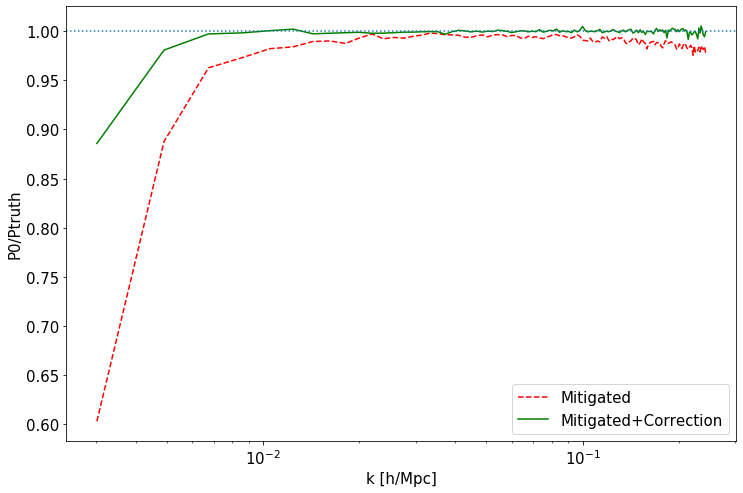

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(
        k[good], Pmitig_mean/Ptrue_mean, 'r--',
        k[good], Pcorrec[:, good].mean(axis=0)/Ptrue_mean, 'g-')
plt.axhline(1.0, ls=':')
plt.legend(['Mitigated', 'Mitigated+Correction'])
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0/Ptruth')
# plt.yscale('log')

Text(0, 0.5, 'P0 [Mpc/h]$^{3}$')

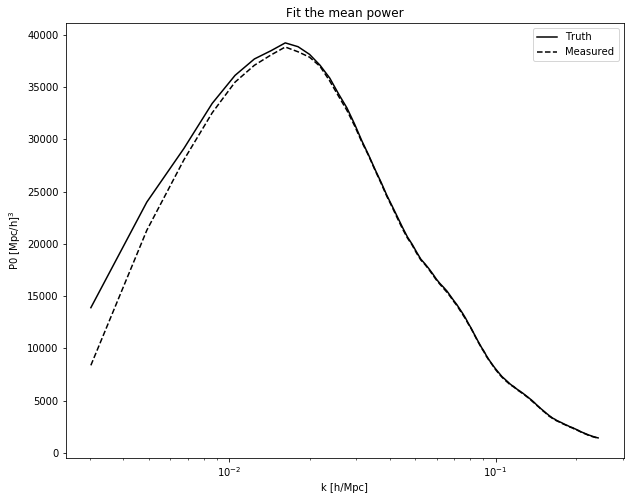

In [31]:
good = k > 0.0015
plt.figure(figsize=(10, 8))
plt.plot(k[good], pknn[:,0,good].mean(axis=0), 'k-',
         k[good], pknn[:,1,good].mean(axis=0), 'k--')
#          k[good], ft.unbias(k[good], pknn[:,1,good].mean(axis=0)), 'r-')

plt.legend(['Truth', 
            'Measured', 
            'Measured + Correction'])
plt.title('Fit the mean power')
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
# plt.savefig('pmean_unbias.png', dpi=300, bbox_inches='tight')

## Fit three groups

In [3]:
def run(seed):
    
    # digitize the spectra
    nparam = 3
    ik = 1
    bins_p = np.percentile(pknn[:, 0, ik], [0, 33.3, 66.6, 100])
    bins_p[-1] = bins_p[-1]+1.0e-5
    bins_c = 0.5*(bins_p[1:]+bins_p[:-1])
    
    #print(bins_p)
    indices = np.digitize(pknn[:, 0, ik], bins_p)

    good = k > 0.0015
    k_ = np.linspace(0.99*k[good].min(), 1.01*k[good].max(), 500)

    print('{:8s}'.format('Sample'), end=' ')
    for xi in range(nparam):
        stri = f'       a[{xi}]'
        print(f'{stri:12s}', end=' ')
    print('')

    mk = {1:'o', 
          2:'s', 
          3:'^'}
    cl = {1:'b',
          2:'orange', 
          3:'g'}
    
    for index in [1, 2, 3]:
        np.random.seed(seed)
        

        sample_i = (indices == index)

        ft = Fitter(k[good], pknn[sample_i][:, 2, good].mean(axis=0))
        ft.minimize(np.random.random(size=nparam))
        
        print('{:8s}:'.format('Sample-%d'%index), end=' ')
        for xi in ft.result.x:
            print(f'{xi:12.4f}', end=' ')
        print('')

        plt.scatter(ft.k, ft.dp, marker=mk[index], label=f'Sample-{index}(P ~ {bins_c[index-1]:.1e})', alpha=0.8)
        plt.plot(k_, ft.model(ft.result.x, k_), '--')


    plt.ylabel(r'$\Delta$P [Mpc/h]$^{3}$', fontsize=15)
    plt.xlabel('k [h/Mpc]', fontsize=15)
    plt.xscale('log')
    plt.xlim(2.0e-3, 3.0e-1)
    _ = plt.legend(fontsize=15)

Sample          a[0]         a[1]         a[2]  
Sample-1:      45.6141      -3.8000      -0.0256 
Sample-2:       0.9722       1.1927      -0.0827 
Sample-3:    -120.8183      13.6005      -0.1845 


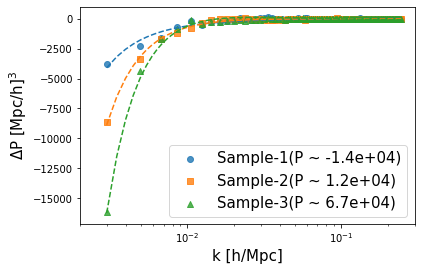

In [4]:
run(42)

Sample          a[0]         a[1]         a[2]  
Sample-1:      45.6138      -3.8000      -0.0256 
Sample-2:       0.9723       1.1927      -0.0827 
Sample-3:    -120.8184      13.6005      -0.1845 


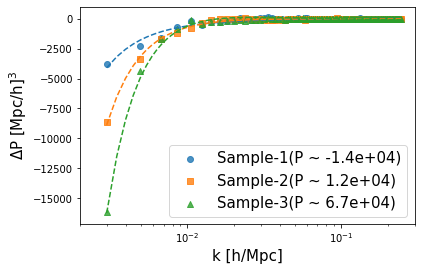

In [5]:
run(98765)

## Fit the mean $\Delta$P

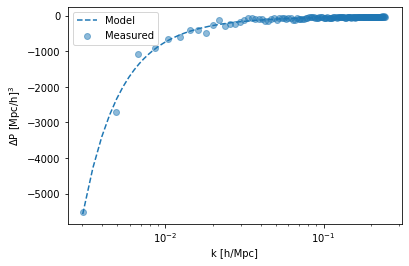

In [14]:
good = k > 0.0015
ft = Fitter(k[good], pknn[:, 2, good].mean(axis=0))
ft.minimize([0.01 for _ in range(4)])
ft.plot()
plt.savefig('deltaP_meanmocks.png', dpi=300, bbox_inches='tight')

In [15]:
ft.result.x

array([-1.81998323e+01, -3.14228943e+00, -4.10594724e-02,  1.00000000e-02])

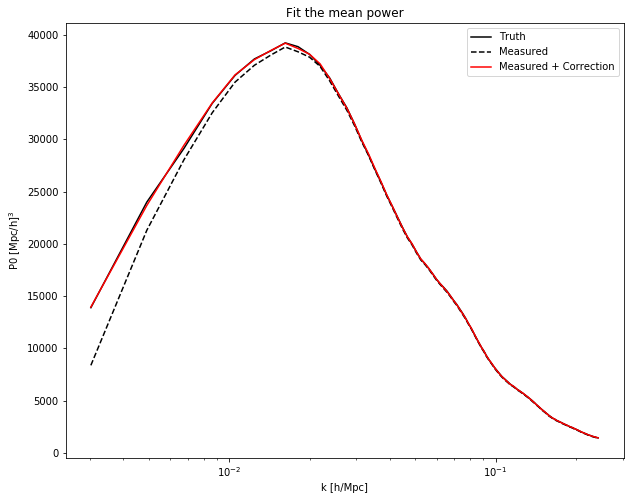

In [16]:
good = k > 0.0015

plt.figure(figsize=(10, 8))
plt.plot(k[good], pknn[:,0,good].mean(axis=0), 'k-',
         k[good], pknn[:,1,good].mean(axis=0), 'k--',
         k[good], ft.unbias(k[good], pknn[:,1,good].mean(axis=0)), 'r-')

plt.legend(['Truth', 
            'Measured', 
            'Measured + Correction'])
plt.title('Fit the mean power')
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
plt.savefig('pmean_unbias.png', dpi=300, bbox_inches='tight')

## Fit the scatter $\Delta$P

In [7]:
good = k > 0.0015
ft1 = Fitter(k[good], pknn[:, 2, good])
ft1.minimize([0.01 for _ in range(10)])

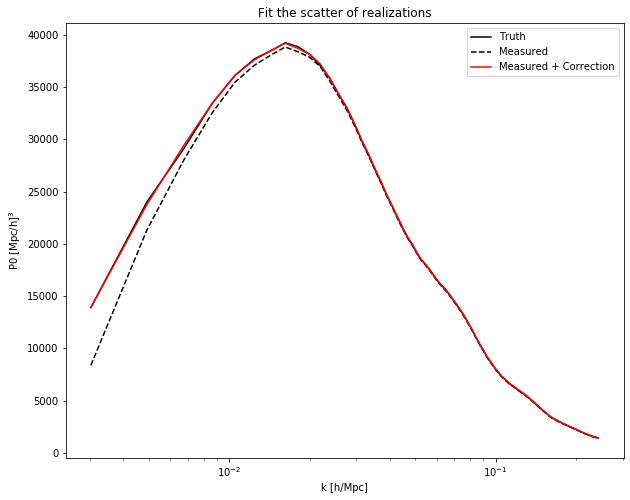

In [8]:
good = k > 0.0015
plt.figure(figsize=(10, 8))
plt.plot(k[good], pknn[:,0,good].mean(axis=0), 'k-',
         k[good], pknn[:,1,good].mean(axis=0), 'k--',
         k[good], ft1.unbias(k[good], pknn[:,1,good].mean(axis=0)), 'r-')

plt.title('Fit the scatter of realizations')
plt.legend(['Truth', 
            'Measured', 
            'Measured + Correction'])
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'P0 [Mpc/h]$^{3}$')
plt.savefig('pscatter_unbias.png', dpi=300, bbox_inches='tight')

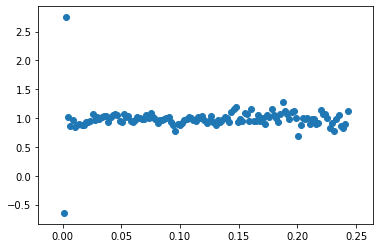

In [74]:
#plt.scatter(pknn[:, , 10], pknn[:, 1, 10], 1.)
plt.scatter(k, pknn[0, 1, :])

In [78]:
ft.result

      fun: 3.740201724659329
 hess_inv: array([[ 6.99008381e-02, -2.15219905e+00,  1.75833192e+01,
        -4.19109307e+01],
       [-2.15219905e+00,  8.49908621e+01, -7.73271237e+02,
         1.95846391e+03],
       [ 1.75833192e+01, -7.73271237e+02,  7.48318409e+03,
        -1.97175543e+04],
       [-4.19109307e+01,  1.95846391e+03, -1.97175543e+04,
         5.34120804e+04]])
      jac: array([1.99675560e-06, 1.49011612e-07, 2.98023224e-08, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 228
      nit: 37
     njev: 38
   status: 0
  success: True
        x: array([   1.18659762,   -6.94116915,   62.59916631, -160.55869765])

In [79]:
ft.dp.shape

(127,)

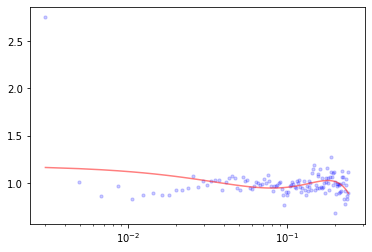

In [80]:
# for i in range(ft.dp.shape[0]):
plt.scatter(ft.k, ft.dp, 10, alpha=0.2, color='b')
    
plt.plot(ft.k, ft.model(ft.result.x, ft.k), alpha=0.5, color='r')
plt.xscale('log')

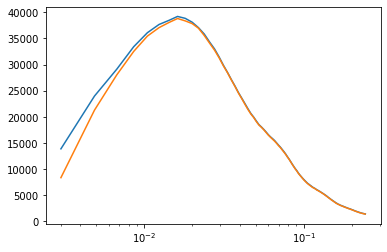

In [82]:
plt.plot(k[good], pknn[:, 0, good].mean(axis=0))
plt.plot(k[good], (pknn[:, 0, good]*pknn[:, 1, good]).mean(axis=0))
# plt.plot(k[good], (pknn[:, 0, good]*pknn[:, 1, good]).mean(axis=0)*ft.model(ft.result.x, ft.k))
plt.xscale('log')

In [4]:
pks = []

for ix in tqdm(range(1, 1000+1)):
    k0, p0 = readpk(pkname(path, cap, 'knownsystot', nside, '0', ix))    
    k1, p1 = readpk(pkname(path, cap, 'knownsystot', nside, '1', ix))    
    k2, p2 = readpk(pkname(path, cap, 'known', nside, '1', ix))        
    
    pks.append([p0, p1, p2])
    
pks = np.array(pks)*1.0e-4
pks.shape

(1000, 3, 128)

In [5]:
pks.shape

(1000, 3, 128)

In [11]:
from scipy.stats import pearsonr

yx = 0
def scatter(ax, x, y, **kw):
    global yx
    pcc = pearsonr(x, y)    
    bc,_,bid = binned_statistic(x, x, statistic='mean')      
    
    rmead = []
    rmin = []
    rmax = []
    for bid_id  in range(bc.size):
        good = bid == bid_id+1
        if good.sum() == 0:
            rmin.append(np.nan)
            rmax.append(np.nan) 
            rmead.append(np.nan)
            continue
        rmin_, rmead_, rmax_ = np.percentile(y[good], [15.9, 50, 84.1]) # 1 sig.
        rmead.append(rmead_)
        rmin.append(rmin_)        
        rmax.append(rmax_)
        
    rmin = np.array(rmin)
    rmax = np.array(rmax)
    rmead = np.array(rmead)
    
    ax.scatter(x, y, 5, **kw)
    ax.errorbar(bc, rmead, yerr=[rmead-rmin, rmax-rmead], 
                color=kw['c'], mfc='w', marker='o', capsize=3)
    #ax.fill_between(bc, rmean-abs(r-rmin), r+abs(rmax-r), color=kw['c'], alpha=0.1)
    
    ax.text(0.7, 0.1-yx*0.05, f'PCC={pcc[0]:.3f}', color=kw['c'], transform=ax.transAxes)
    
    yx += 1 

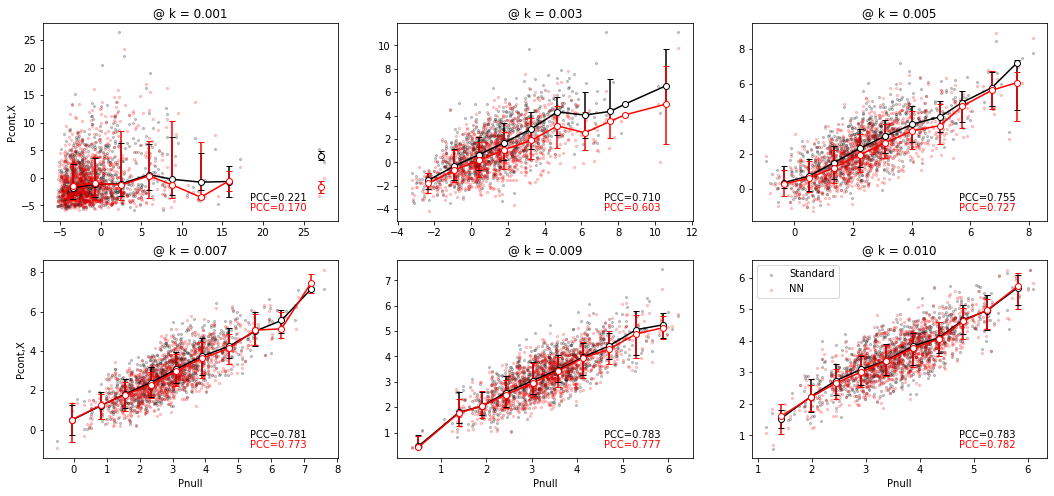

In [12]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X')    

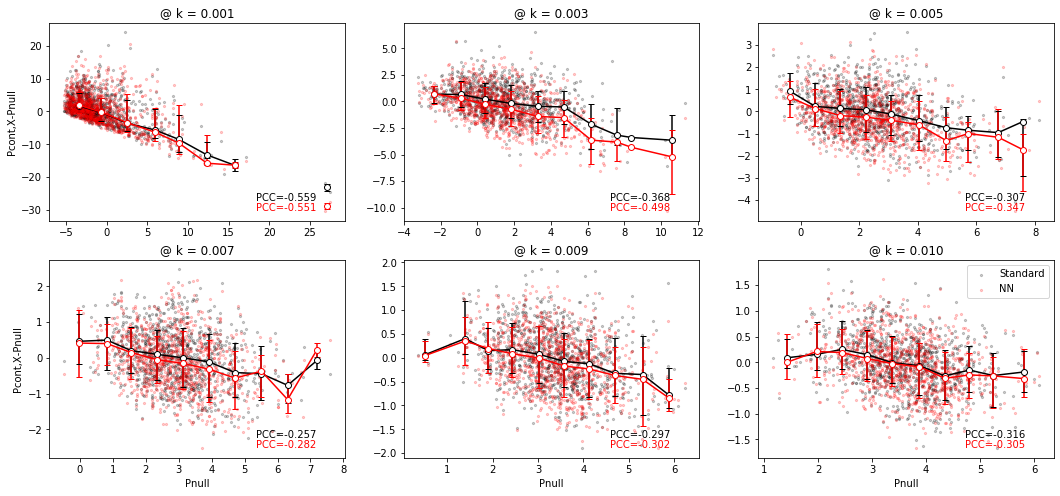

In [13]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix]-pks[:, 0, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix]-pks[:, 0, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X-Pnull')

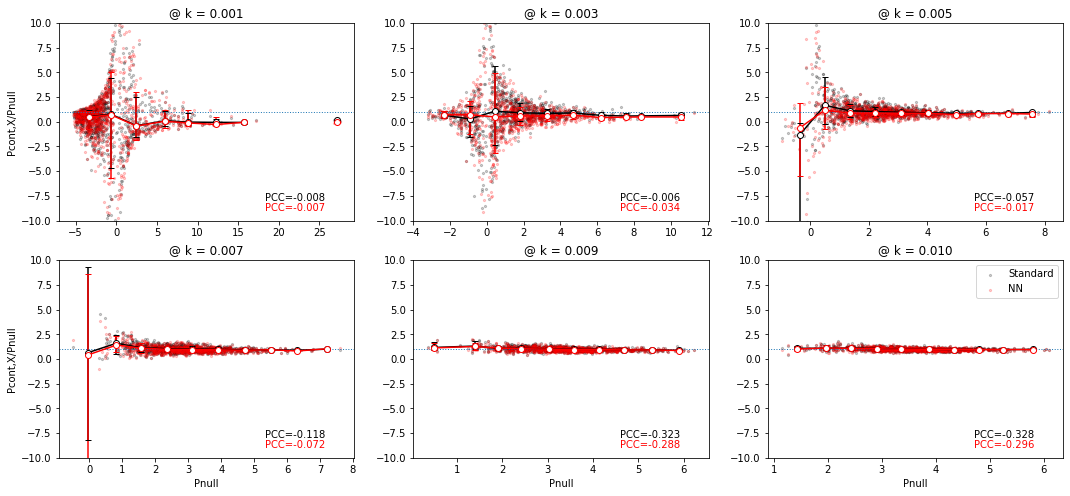

In [16]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))
ax = ax.flatten()

yx = 0
for i, ix in enumerate([0, 1, 2, 3, 4, 5]):
    scatter(ax[i], pks[:, 0, ix], pks[:, 1, ix]/pks[:, 0, ix], c='k', alpha=0.2, label='Standard')
    scatter(ax[i], pks[:, 0, ix], pks[:, 2, ix]/pks[:, 0, ix], c='r', alpha=0.2, label='NN')
    ax[i].set_title(f'@ k = {k0[ix]:.3f}')
    ax[i].axhline(1, ls=':', lw=1)
    ax[i].set_ylim(-10, 10)
    yx = 0
    
ax[-1].legend()

for axi in ax[-3:]:
    axi.set_xlabel('Pnull')
    
for i in [0, 3]:
    ax[i].set_ylabel('Pcont,X/Pnull')

In [36]:
dp = {'standard':[], 'nnknown':[]}

for ix in tqdm(range(1, 1000+1)):
    k0, p0 = readpk(pkname(path, cap, 'knownsystot', nside, '0', ix))    
    k1, p1 = readpk(pkname(path, cap, 'knownsystot', nside, '1', ix))    
    k2, p2 = readpk(pkname(path, cap, 'known', nside, '1', ix))        
    
    dp['standard'].append([p0, p1-p0])
    dp['nnknown'].append([p0, p2-p0])
    
dpc = {}
for n,v in dp.items():
    dpc[n] = np.array(v)*1.0e-4  

In [6]:
plt.rc('font', size=18)

Text(0.5, 1.0, 'w/ shotnoise subtraction')

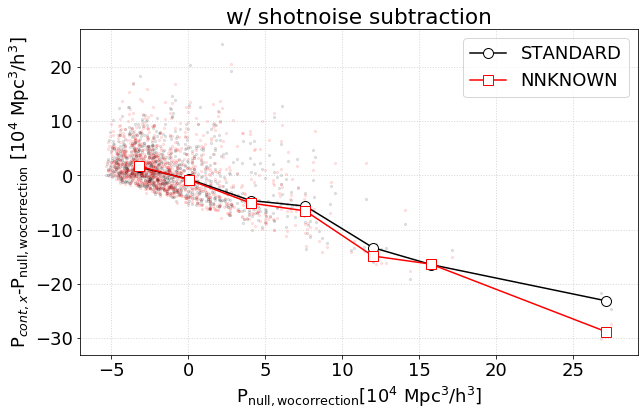

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(-5.5, 30., num=10)

colors = ['k', 'red']
markers = ['o', 's']

for i, (n, v) in enumerate(dpc.items()):
    r,_,_ = binned_statistic(v[:, 0], v[:, 1], 
                             statistic='median', bins=bins)  
    bc,_,_ = binned_statistic(v[:, 0], v[:, 0], 
                             statistic='mean', bins=bins)  
    #std,_,_ = binned_statistic(v[:, 0], v[:, 1], 
    #                         statistic='std', bins=bins)  
    #nm,_,_ = binned_statistic(v[:, 0], np.ones(v.shape[0]), 
    #                         statistic='count', bins=bins)      
    
    ax.scatter(v[:, 0], v[:,1], 5, color=colors[i], alpha=0.1)    
    msk = np.isfinite(r)
    ax.plot(bc[msk], r[msk],
            marker=markers[i], color=colors[i], mfc='w', 
            label=n.upper(), ms=10)
    
ax.grid(lw=1, alpha=0.5, ls=':')  
ax.set(xlabel=r'P$_{{\rm null, wo correction}}$[10$^{4}$ Mpc$^{3}$/h$^{3}$]', 
       ylabel=r'P$_{cont, x}$-P$_{{\rm null, wo correction}}$ [10$^{4}$ Mpc$^{3}$/h$^{3}$]')
ax.legend()
ax.set_title('w/ shotnoise subtraction')

In [37]:
np.percentile(dpc['nnknown'][:, 0], [0, 100])

array([-5.30924267, 27.48701987])

Text(0.5, 1.0, 'w shotnoise subtraction at k=0.0014')

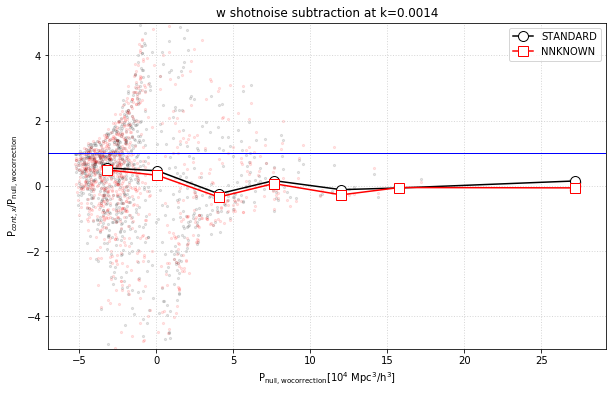

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(-5.5, 30., num=10)
#bins = np.linspace(-1, 1.)
# bins = np.linspace(-4, 12.)

colors = ['k', 'red']
markers = ['o', 's']

for i, (n, v) in enumerate(dpc.items()):
    r,_,_ = binned_statistic(v[:, 0], (v[:, 1]+v[:, 0])/v[:, 0], 
                             statistic='median', bins=bins)  
#     r1,_,_ = binned_statistic(v[:, 0], (v[:, 1]+v[:, 0])/v[:, 0], 
#                              statistic='mean', bins=bins)      
    bc,_,_ = binned_statistic(v[:, 0], v[:, 0], 
                             statistic='mean', bins=bins)  
    #std,_,_ = binned_statistic(v[:, 0], v[:, 1], 
    #                         statistic='std', bins=bins)  
    #nm,_,_ = binned_statistic(v[:, 0], np.ones(v.shape[0]), 
    #                         statistic='count', bins=bins)      
    
    ax.scatter(v[:, 0], v[:, 1]/v[:, 0]+1.0, 5, color=colors[i], alpha=0.1)    
    msk = np.isfinite(r)
    ax.plot(bc[msk], r[msk],
            marker=markers[i], color=colors[i], mfc='w', 
            label=n.upper(), ms=10)
    #ax.plot(bc[msk], r1[msk],
    #        marker=markers[i], color=colors[i], mfc='w', ms=10, ls='--')

ax.axhline(1., ls='-', lw=1, color='b')    
    
ax.grid(lw=1, alpha=0.5, ls=':')  
ax.set(xlabel=r'P$_{{\rm null, wo correction}}$[10$^{4}$ Mpc$^{3}$/h$^{3}$]', 
       ylabel=r'P$_{cont, x}$/P$_{{\rm null, wo correction}}$') # [10$^{4}$ Mpc$^{3}$/h$^{3}$]
ax.set(ylim=(-5., 5.))

ax.legend()
ax.set_title(f'w shotnoise subtraction at k={k0:.4f}')